In [1]:
# put download.sh and this notebook in the same folder on google drive. Remember to modify path!
from google.colab import drive
drive.mount('/content/gdrive')

import os

path = "/content/gdrive/MyDrive/DL_Project/Data"
os.chdir(path)

Mounted at /content/gdrive


In [2]:
import librosa
import os
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
#from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import csv
import torch.optim as optim
from tqdm import tqdm
from os.path import exists
import math

# **FEATURE EXTRACTION**

In [ ]:
configs = [
    [2048, 512, 2048],
    [2048, 512, 1024],
    [2048, 1024, 1024],
    [1024, 512, 1024],
    [1024, 256, 1024]
]

def process_data(personality_dir="Personality_Scores", metadata_dir="Metadata", audio_dir="Audio_clips"):
    df_personality = get_personality_scores(personality_dir)
    df_metadata = get_metadata(metadata_dir)
    df_feature = get_features(audio_dir)
    
    df = pd.merge(df_personality, df_metadata, left_on="Clip_ID", right_on="Clip_ID")
    df = pd.merge(df, df_feature, left_on="Clip_ID", right_on="Clip_ID")
    
    return df

def get_personality_scores(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Score_011.csv")

    for i in range(1, 11):
        df_tmp = pd.read_csv(data_dir_path + f"/Score_0{i:02d}.csv")
        
        df["Extraversion"] = df["Extraversion"] + df_tmp["Extraversion"]
        df["Agreeableness"] = df["Agreeableness"] + df_tmp["Agreeableness"]
        df["Conscientiousness"] = df["Conscientiousness"] + df_tmp["Conscientiousness"]
        df["Neuroticism"] = df["Neuroticism"] + df_tmp["Neuroticism"]
        df["Openness"] = df["Openness"] + df_tmp["Openness"]

    df["Extraversion"] = df["Extraversion"] / 11
    df["Agreeableness"] = df["Agreeableness"] / 11
    df["Conscientiousness"] = df["Conscientiousness"] / 11
    df["Neuroticism"] = df["Neuroticism"] / 11
    df["Openness"] = df["Openness"] / 11
    
    return df

def get_metadata(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Metadata.csv")
    return df

def get_features(data_dir_path):
    data = []
    
    for filename in os.listdir(data_dir_path):
        f = os.path.join(data_dir_path, filename)
        
        y, sr = librosa.load(f)
        output = []
        pad_len = 0
        for config in configs:
            s = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=config[0], hop_length=config[1], win_length=config[2])
            pad_len = max(pad_len, len(s[0]))
            output.append(s)
        
        for i, cur in enumerate(output):
            cur = np.pad(cur, ((0,0), (0, pad_len-len(cur[0]))))
            output[i] = cur
        output = np.array(output)

        data.append([filename.split(".")[0], output])
    
    df = pd.DataFrame(data, columns=["Clip_ID", "features"])
    return df


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

In [ ]:
if exists("./processed_data.pkl"):
  with open("./processed_data.pkl", 'rb') as f:
    data = pickle.load(f)
else:
  ! bash download.sh
  data = process_data()
  data.to_pickle("processed_data.pkl")

# **HYPER PARAMETERS**

In [ ]:
agg_type = 'numerical'
features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

if agg_type == 'numerical':
    agg = ''
else:
    agg = '_categorical'

batch_size = 8
lr = 1e-3
epochs = 200

# **DATA LOADER**

In [ ]:
if agg_type=='numerical':
    cutoff = 0
    data['Extraversion'] = np.where(data['Extraversion'] > cutoff,1,0)
    data['Agreeableness'] = np.where(data['Agreeableness'] > cutoff,1,0)
    data['Conscientiousness'] = np.where(data['Conscientiousness'] > cutoff,1,0)
    data['Neuroticism'] = np.where(data['Neuroticism'] > cutoff,1,0)
    data['Openness'] = np.where(data['Openness'] > cutoff,1,0)


In [ ]:
#Split dataframe into train, validation, and test sets
train, val, test = np.split(
    data.sample(frac=1, random_state=101),
    [int(.7*len(data)), int(.85*len(data))]
)

In [ ]:

class LibriSamplesTrain(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # 5 * 128 * T
        X = X.T # T * 128 * 5

        ys = [self.dataframe[f].iloc[ind] for f in features]
        Y = torch.Tensor(np.array(ys)) # 5
        return X, Y

    def collate_fn(batch):
        batch_x = [x for x,y in batch] # (B * T * 128 * 5)
        batch_y = [y for x,y in batch] # (B * 5)
        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5
        
        lengths_y = [y.shape[0] for y in batch_y] 
        batch_y_pad = pad_sequence(batch_y, batch_first=True) # B * 5

        return batch_x_pad, batch_y_pad, torch.Tensor(lengths_x), torch.Tensor(lengths_y)

class LibriSamplesTest(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # T * 128 * 5
        return X

    def collate_fn(batch):
        batch_x = [x for x,y in batch] # (B * T * 128 * 5)

        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5

        return batch_x_pad, torch.Tensor(lengths_x)


In [ ]:
train_data = LibriSamplesTrain(train)
val_data = LibriSamplesTrain(val)
test_data = LibriSamplesTest(test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn = LibriSamplesTrain.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTrain.collate_fn) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTest.collate_fn) 

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  8
Train dataset samples = 448, batches = 56
Val dataset samples = 96, batches = 12
Test dataset samples = 96, batches = 12


# **MODEL**

In [ ]:
"""
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
        
        self.embedding = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.AvgPool2d((3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.AvgPool2d((3, 3))
        )

        self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        self.classification = nn.Sequential(
            nn.Linear(512, 2048),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout2d(0.3),
            nn.Linear(512, 5),
        )

    def forward(self, x):      
        x = x.transpose(1, 3) # B * 5 * 128 * T 
        out = self.embedding(x) # B * 512 * H * W (H and W are from CNN)
        out = self.flatten(out) # B * 512 * 1
        out = self.classification(out) # B * num_class
        out = torch.sigmoid(out)
        return out

"""

'\nclass Network(nn.Module):\n\n    def __init__(self):\n\n        super(Network, self).__init__()\n        \n        self.embedding = nn.Sequential(\n            nn.Conv2d(in_channels=5, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(128),\n            nn.GELU(),\n            nn.AvgPool2d((3, 3)),\n            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),\n            nn.BatchNorm2d(256),\n            nn.GELU(),\n            nn.Dropout2d(0.2),\n            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(512),\n            nn.GELU(),\n            nn.AvgPool2d((3, 3))\n        )\n\n        self.flatten = nn.Sequential(\n            nn.AdaptiveAvgPool2d((1, 1)),\n            nn.Flatten()\n        )\n\n        self.classification = nn.Sequential(\n            nn.Linear(512, 2048),\n            nn.BatchNorm1d(2048),\n     

In [ ]:
class InvertedResidualBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expand_ratio):
        super().__init__() # Just have to do this for all nn.Module classes

        # Can only do identity residual connection if input & output are the
        # same channel & spatial shape.
        if stride == 1 and in_channels == out_channels:
            self.do_identity = True
        else:
            self.do_identity = False
        
        # Expand Ratio is like 6, so hidden_dim >> in_channels
        hidden_dim = in_channels * expand_ratio

        self.spatial_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(in_channels, in_channels, 
                      kernel_size = 7, 
                      padding = 7//2, 
                      stride = stride, 
                      groups = in_channels, 
                      bias = False), # bias = False, True if no BatchNorm2d
            nn.BatchNorm2d(in_channels)
        )

        self.feature_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(in_channels, hidden_dim, 
                      kernel_size = 1, 
                      stride = 1, 
                      padding = 1//2, # tried 1//2, 0
                      bias = True), # bias = False, True if no BatchNorm2d
            nn.GELU() # ReLU6, GELU
        )


        self.bottleneck_channels = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(hidden_dim, out_channels, 
                      kernel_size = 1, 
                      stride = 1, 
                      padding = 0, 
                      bias = True) # bias = False, True if no BatchNorm2d
        )

    def forward(self, x):
        out_spatial_mixing = self.spatial_mixing(x)
        out_feature_mixing = self.feature_mixing(out_spatial_mixing)
        out_bottleneck_channels = self.bottleneck_channels(out_feature_mixing)

        if self.do_identity:
            return x + out_bottleneck_channels
        else:
            return out_bottleneck_channels




In [ ]:
class ConvNeXt(nn.Module):

    def __init__(self, num_classes = 5):
        super().__init__()

        num_out_channels = 512

        last_linear_layer = 2048 # tried 512, 550, 740, 750, 760

        # last_linear_layer: to reduce the number of parameters below 35M, I tried the max number of out_features possible keeping total parameters under 35MN (which is 760 out_features) 
        # 740 out_features could not produce test accuracy more than 61% under config 1
        # 512 and 550 achieved much higher accuracies than the other higher sizes (740, 750, 760) of last linear layer

        self.num_classes = num_classes

        in_chan = 64

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels= in_chan, kernel_size=3, stride=1, padding=1), # ADDED THIS 
            nn.BatchNorm2d(in_chan),
            nn.GELU()
        )

        """

        self.stem = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(64, in_channels, 
                      kernel_size = 3, 
                      stride = 2, 
                      padding = 3//2, 
                      bias = False),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
            )

        """

        # alternative-1 considered
        self.stage_cfgs = [
            # expand_ratio, channels, # blocks, stride of first block
            [4,  64, 3, 2],
            [8, 128, 3, 2],
            [8, 256, 3, 2],
            [8, 512, 2, 2],
            [8, 512, 1, 1]
            ]
            
        """ 
        alternative-2 considered
            [8,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
        """

        """
        alternative-3 considered
            [6,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
        """


        in_channels = in_chan


        # Let's make the layers
        layers = []
        for curr_stage in self.stage_cfgs:
            expand_ratio, num_channels, num_blocks, stride = curr_stage
            
            for block_idx in range(num_blocks):
                out_channels = num_channels
                layers.append(InvertedResidualBlock(
                    in_channels = in_channels,
                    out_channels = out_channels,
                    # only have non-trivial stride if first block
                    stride = stride if block_idx == 0 else 1, 
                    expand_ratio = expand_ratio
                ))
                # In channels of the next block is the out_channels of the current one
                in_channels = out_channels
            
        self.layers = nn.Sequential(*layers) # Done, save them to the class



        # Some final feature mixing
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 
                      num_out_channels, 
                      kernel_size = 1, 
                      padding = 0, 
                      stride = 1, 
                      bias = False),
            nn.BatchNorm2d(num_out_channels),
            nn.GELU(), # options: ReLU6, GELU
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        
        # Now, we need to build the final classification layer.
        self.cls_layer = nn.Sequential(
            # TODO: Fill this in!
            nn.Linear(num_out_channels, last_linear_layer),
            nn.BatchNorm1d(last_linear_layer),                  # tried with nn.GELU() as well instead of nn.BatchNorm1d() and nn.ReLU6()
            nn.GELU(),                                          # tried ReLU, ReLU6, GELU #review
            nn.Dropout(p = 0.25),                               # 0.2, 0.25
            nn.Linear(last_linear_layer, self.num_classes)
            )

        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):

        x = x.transpose(1, 3)

        out = self.cnn(x)

        #out = self.stem(out)
        layers_out = self.layers(out)
        feat_out = self.final_block(layers_out)
        out = self.cls_layer(feat_out)
        out = torch.sigmoid(out)
        return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ConvNeXt().to(device)
print(model)

ConvNeXt(
  (cnn): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
  )
  (layers): Sequential(
    (0): InvertedResidualBlock(
      (spatial_mixing): Sequential(
        (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (feature_mixing): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): GELU()
      )
      (bottleneck_channels): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): InvertedResidualBlock(
      (spatial_mixing): Sequential(
        (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5)

# **TRAIN**

In [ ]:
train_acc_list = list()
train_loss_list = list()
lr_list = list()
validation_acc_list = list()

train_separate_acc_list = list()
val_separate_acc_list = list()


print('train_loader: ', len(train_loader))


for epoch in range(epochs):

    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    total_loss = 0
    train_num_correct =0

    #train_separate_acc = 0
    train_separate_count = [0]*5


    #train
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() 

        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        output=model(x)
        prediction_out = (output>0.5).float()

        #print(f"output: {output.shape}")
        #print(f"y: {y.shape}")


        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        train_num_correct += int((prediction_out==y).sum())
        total_loss += loss.item()
        # print("loss", loss.item())

        for i in range(len(prediction_out)):
            predict, real = prediction_out[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    train_separate_count[j] = train_separate_count[j] + 1



        batch_bar.set_postfix(
          loss="{:.04f}".format(float(total_loss/(i+1)))
        )
        batch_bar.update()

    # torch.cuda.empty_cache()

    # validate
    model.eval()
    batch_bar.close()
    val_num_correct = 0
    val_separate_acc = 0
    val_separate_count = [0]*5

    for i, data in enumerate(val_loader):
        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        val_outputs = model(x)
        prediction_val = (val_outputs>0.5).float()


        cur_count = 0
        for i in range(len(prediction_val)):
            predict, real = prediction_val[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    cur_count += 1
                    val_separate_count[j] = val_separate_count[j] + 1
        
        val_num_correct += cur_count


    torch.cuda.empty_cache()

    train_acc = 100 * (train_num_correct/5) / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    lr = float(optimizer.param_groups[0]['lr'])
    validation_acc = 100 * (val_num_correct/5) / (len(val_loader)*batch_size)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr_list.append(lr)
    validation_acc_list.append(validation_acc)


    train_separate_acc = 100 * np.array(train_separate_count) / (len(train_loader)*batch_size)
    train_separate_acc_list.append(train_separate_acc)


    val_separate_acc = 100 * np.array(val_separate_count) / (len(val_loader)*batch_size)
    val_separate_acc_list.append(val_separate_acc)


    
    #train_loss = float(total_loss / len(train_loader))
    #lr = float(optimizer.param_groups[0]['lr'])
    #validation_acc = 100 * val_num_correct / (len(val_loader)*batch_size)


    
    #train_loss_list.append(train_loss)
    #lr_list.append(lr)
    #validation_acc_list.append(validation_acc)


    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {}, Learning Rate {}, Val Acc {:.04f}%".format(
        epoch + 1,
        epochs,
        train_acc,
        train_loss,
        lr,
        validation_acc,
        ))
    
    #print(val_separate_acc)
    
    scheduler.step()

train_loader:  56


Train:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/200: Train Acc 69.8214%, Train Loss 0.6359561852046421, Learning Rate 0.001, Val Acc 68.5417%


Epoch 2/200: Train Acc 71.9196%, Train Loss 0.6183273504887309, Learning Rate 0.001, Val Acc 69.5833%


Epoch 3/200: Train Acc 70.9821%, Train Loss 0.6272959570799556, Learning Rate 0.001, Val Acc 73.3333%


Epoch 4/200: Train Acc 70.8929%, Train Loss 0.6003201327153614, Learning Rate 0.001, Val Acc 71.4583%


Epoch 5/200: Train Acc 71.1161%, Train Loss 0.6058401305760656, Learning Rate 0.001, Val Acc 70.6250%


Epoch 6/200: Train Acc 71.9196%, Train Loss 0.5970977645899568, Learning Rate 0.001, Val Acc 70.8333%


Epoch 7/200: Train Acc 71.5179%, Train Loss 0.6065023270036493, Learning Rate 0.001, Val Acc 75.0000%


Epoch 8/200: Train Acc 72.1875%, Train Loss 0.6086707588817392, Learning Rate 0.001, Val Acc 74.1667%


Epoch 9/200: Train Acc 71.6071%, Train Loss 0.6073581469910485, Learning Rate 0.001, Val Acc 74.5833%


Epoch 10/200: Train Acc 71.5625%, Train Loss 0.5986036131424564, Learning Rate 0.001, Val Acc 73.5417%


Epoch 11/200: Train Acc 72.4554%, Train Loss 0.6158118098974228, Learning Rate 0.001, Val Acc 70.8333%


Epoch 12/200: Train Acc 71.5179%, Train Loss 0.5868717006274632, Learning Rate 0.001, Val Acc 71.4583%


Epoch 13/200: Train Acc 72.4554%, Train Loss 0.599220905985151, Learning Rate 0.001, Val Acc 73.9583%


Epoch 14/200: Train Acc 72.8125%, Train Loss 0.602873117263828, Learning Rate 0.001, Val Acc 74.1667%


Epoch 15/200: Train Acc 72.5893%, Train Loss 0.5760961244148868, Learning Rate 0.001, Val Acc 72.9167%


Epoch 16/200: Train Acc 71.7411%, Train Loss 0.5958133941250188, Learning Rate 0.001, Val Acc 74.1667%


Epoch 17/200: Train Acc 72.1429%, Train Loss 0.5793321457292352, Learning Rate 0.001, Val Acc 72.9167%


Epoch 18/200: Train Acc 71.5179%, Train Loss 0.5766199837837901, Learning Rate 0.001, Val Acc 72.7083%


Epoch 19/200: Train Acc 72.1429%, Train Loss 0.5700614899396896, Learning Rate 0.001, Val Acc 74.1667%


Epoch 20/200: Train Acc 72.2768%, Train Loss 0.5767924641924245, Learning Rate 0.001, Val Acc 72.2917%


Epoch 21/200: Train Acc 72.5000%, Train Loss 0.5715344734489918, Learning Rate 0.0005, Val Acc 73.7500%


Epoch 22/200: Train Acc 73.1696%, Train Loss 0.5602162847561496, Learning Rate 0.0005, Val Acc 73.9583%


Epoch 23/200: Train Acc 73.2589%, Train Loss 0.5606229592646871, Learning Rate 0.0005, Val Acc 72.9167%


Epoch 24/200: Train Acc 73.0357%, Train Loss 0.5605259846363749, Learning Rate 0.0005, Val Acc 72.0833%


Epoch 25/200: Train Acc 73.0804%, Train Loss 0.5638894268444606, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 26/200: Train Acc 72.9911%, Train Loss 0.5657878065747874, Learning Rate 0.0005, Val Acc 73.9583%


Epoch 27/200: Train Acc 72.7679%, Train Loss 0.5573796688445977, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 28/200: Train Acc 72.2768%, Train Loss 0.5558073903833117, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 29/200: Train Acc 73.2589%, Train Loss 0.560225094535521, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 30/200: Train Acc 73.3929%, Train Loss 0.5471528411975929, Learning Rate 0.0005, Val Acc 69.1667%


Epoch 31/200: Train Acc 72.7679%, Train Loss 0.5582672410777637, Learning Rate 0.0005, Val Acc 72.9167%


Epoch 32/200: Train Acc 72.6339%, Train Loss 0.5635929501482418, Learning Rate 0.0005, Val Acc 72.9167%


Epoch 33/200: Train Acc 73.1250%, Train Loss 0.5606216261429446, Learning Rate 0.0005, Val Acc 73.9583%


Epoch 34/200: Train Acc 72.0089%, Train Loss 0.5660673358610698, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 35/200: Train Acc 72.7679%, Train Loss 0.5634703210421971, Learning Rate 0.0005, Val Acc 73.1250%


Epoch 36/200: Train Acc 72.0536%, Train Loss 0.5672107642250401, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 37/200: Train Acc 72.9911%, Train Loss 0.5572267456778458, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 38/200: Train Acc 72.5000%, Train Loss 0.5605685125504222, Learning Rate 0.0005, Val Acc 68.9583%


Epoch 39/200: Train Acc 73.3482%, Train Loss 0.5570286948766027, Learning Rate 0.0005, Val Acc 70.2083%


Epoch 40/200: Train Acc 72.9464%, Train Loss 0.5503399249698434, Learning Rate 0.0005, Val Acc 74.1667%


Epoch 41/200: Train Acc 73.0357%, Train Loss 0.5485220492950508, Learning Rate 0.00025, Val Acc 74.3750%


Epoch 42/200: Train Acc 73.2589%, Train Loss 0.5438159379575934, Learning Rate 0.00025, Val Acc 73.5417%


Epoch 43/200: Train Acc 72.9911%, Train Loss 0.5355955404894692, Learning Rate 0.00025, Val Acc 73.3333%


Epoch 44/200: Train Acc 72.6339%, Train Loss 0.549322495503085, Learning Rate 0.00025, Val Acc 74.1667%


Epoch 45/200: Train Acc 73.4821%, Train Loss 0.5352484988314765, Learning Rate 0.00025, Val Acc 75.0000%


Epoch 46/200: Train Acc 73.2143%, Train Loss 0.5364759670836585, Learning Rate 0.00025, Val Acc 74.3750%


Epoch 47/200: Train Acc 73.5268%, Train Loss 0.5446557881576675, Learning Rate 0.00025, Val Acc 74.3750%


Epoch 48/200: Train Acc 73.3036%, Train Loss 0.5469829381576606, Learning Rate 0.00025, Val Acc 73.5417%


Epoch 49/200: Train Acc 72.6339%, Train Loss 0.5443862128470626, Learning Rate 0.00025, Val Acc 72.5000%


Epoch 50/200: Train Acc 73.4821%, Train Loss 0.5452546780662877, Learning Rate 0.00025, Val Acc 69.5833%


Epoch 51/200: Train Acc 73.3036%, Train Loss 0.5419005416333675, Learning Rate 0.00025, Val Acc 73.9583%


Epoch 52/200: Train Acc 73.8839%, Train Loss 0.5377907811530999, Learning Rate 0.00025, Val Acc 74.5833%


Epoch 53/200: Train Acc 73.4821%, Train Loss 0.5348320257450853, Learning Rate 0.00025, Val Acc 74.1667%


Epoch 54/200: Train Acc 72.9018%, Train Loss 0.5533296790506158, Learning Rate 0.00025, Val Acc 73.3333%


Epoch 55/200: Train Acc 73.7054%, Train Loss 0.5302650066358703, Learning Rate 0.00025, Val Acc 74.3750%


Epoch 56/200: Train Acc 73.1696%, Train Loss 0.5373396921370711, Learning Rate 0.00025, Val Acc 73.9583%


Epoch 57/200: Train Acc 73.4375%, Train Loss 0.5183156446686813, Learning Rate 0.00025, Val Acc 69.7917%


Epoch 58/200: Train Acc 73.8839%, Train Loss 0.5300904240991388, Learning Rate 0.00025, Val Acc 74.1667%


Epoch 59/200: Train Acc 74.5536%, Train Loss 0.5251794223274503, Learning Rate 0.00025, Val Acc 73.5417%


Epoch 60/200: Train Acc 74.5089%, Train Loss 0.5126254579850605, Learning Rate 0.00025, Val Acc 74.5833%


Epoch 61/200: Train Acc 74.9554%, Train Loss 0.507424325815269, Learning Rate 0.000125, Val Acc 73.9583%


Epoch 62/200: Train Acc 75.5804%, Train Loss 0.4806124876652445, Learning Rate 0.000125, Val Acc 74.1667%


Epoch 63/200: Train Acc 76.2054%, Train Loss 0.49398625801716534, Learning Rate 0.000125, Val Acc 73.9583%


Epoch 64/200: Train Acc 76.6964%, Train Loss 0.47712709807923864, Learning Rate 0.000125, Val Acc 74.1667%


Epoch 65/200: Train Acc 76.9643%, Train Loss 0.4684842489659786, Learning Rate 0.000125, Val Acc 73.3333%


Epoch 66/200: Train Acc 76.6964%, Train Loss 0.46996193325945307, Learning Rate 0.000125, Val Acc 72.9167%


Epoch 67/200: Train Acc 77.3661%, Train Loss 0.46522084197827746, Learning Rate 0.000125, Val Acc 73.9583%


Epoch 68/200: Train Acc 78.7500%, Train Loss 0.4566241481474468, Learning Rate 0.000125, Val Acc 71.8750%


Epoch 69/200: Train Acc 78.0804%, Train Loss 0.4669442858014788, Learning Rate 0.000125, Val Acc 65.0000%


Epoch 70/200: Train Acc 77.9018%, Train Loss 0.4503714255988598, Learning Rate 0.000125, Val Acc 75.2083%


Epoch 71/200: Train Acc 78.4821%, Train Loss 0.4413709523422377, Learning Rate 0.000125, Val Acc 73.7500%


Epoch 72/200: Train Acc 78.8393%, Train Loss 0.4419864165995802, Learning Rate 0.000125, Val Acc 68.5417%


Epoch 73/200: Train Acc 78.5268%, Train Loss 0.4365192401622023, Learning Rate 0.000125, Val Acc 71.2500%


Epoch 74/200: Train Acc 79.4643%, Train Loss 0.43305584149701254, Learning Rate 0.000125, Val Acc 64.1667%


Epoch 75/200: Train Acc 80.4018%, Train Loss 0.4236274728817599, Learning Rate 0.000125, Val Acc 73.9583%


Epoch 76/200: Train Acc 79.7768%, Train Loss 0.42542553480182377, Learning Rate 0.000125, Val Acc 73.7500%


Epoch 77/200: Train Acc 79.3304%, Train Loss 0.422369757933276, Learning Rate 0.000125, Val Acc 73.7500%


Epoch 78/200: Train Acc 80.7589%, Train Loss 0.4156971291771957, Learning Rate 0.000125, Val Acc 68.9583%


Epoch 79/200: Train Acc 80.9821%, Train Loss 0.40654004285378115, Learning Rate 0.000125, Val Acc 75.2083%


Epoch 80/200: Train Acc 81.3839%, Train Loss 0.39857769065669607, Learning Rate 0.000125, Val Acc 73.9583%


Epoch 81/200: Train Acc 82.5446%, Train Loss 0.38200212536113604, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 82/200: Train Acc 83.6161%, Train Loss 0.37537271502826897, Learning Rate 6.25e-05, Val Acc 72.5000%


Epoch 83/200: Train Acc 83.7500%, Train Loss 0.3655647896230221, Learning Rate 6.25e-05, Val Acc 70.6250%


Epoch 84/200: Train Acc 84.4196%, Train Loss 0.3562971409410238, Learning Rate 6.25e-05, Val Acc 69.7917%


Epoch 85/200: Train Acc 83.7054%, Train Loss 0.35508446980799946, Learning Rate 6.25e-05, Val Acc 73.1250%


Epoch 86/200: Train Acc 84.3750%, Train Loss 0.33771271418247906, Learning Rate 6.25e-05, Val Acc 69.5833%


Epoch 87/200: Train Acc 84.0179%, Train Loss 0.3440326010542257, Learning Rate 6.25e-05, Val Acc 70.4167%


Epoch 88/200: Train Acc 85.0000%, Train Loss 0.3402005569743259, Learning Rate 6.25e-05, Val Acc 73.1250%


Epoch 89/200: Train Acc 84.8661%, Train Loss 0.3285339402833155, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 90/200: Train Acc 85.4464%, Train Loss 0.33454728472445694, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 91/200: Train Acc 86.1607%, Train Loss 0.32169945990400656, Learning Rate 6.25e-05, Val Acc 72.2917%


Epoch 92/200: Train Acc 86.8750%, Train Loss 0.3105976509728602, Learning Rate 6.25e-05, Val Acc 73.1250%


Epoch 93/200: Train Acc 86.5625%, Train Loss 0.3095574647720371, Learning Rate 6.25e-05, Val Acc 71.2500%


Epoch 94/200: Train Acc 86.6071%, Train Loss 0.28991128637322355, Learning Rate 6.25e-05, Val Acc 71.2500%


Epoch 95/200: Train Acc 85.8482%, Train Loss 0.3052886554173061, Learning Rate 6.25e-05, Val Acc 67.2917%


Epoch 96/200: Train Acc 87.5000%, Train Loss 0.28608011906700476, Learning Rate 6.25e-05, Val Acc 70.6250%


Epoch 97/200: Train Acc 88.2143%, Train Loss 0.27277495791869505, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 98/200: Train Acc 87.9911%, Train Loss 0.2747539434848087, Learning Rate 6.25e-05, Val Acc 69.7917%


Epoch 99/200: Train Acc 88.5714%, Train Loss 0.27043428644537926, Learning Rate 6.25e-05, Val Acc 71.4583%


Epoch 100/200: Train Acc 88.5714%, Train Loss 0.26277129711317165, Learning Rate 6.25e-05, Val Acc 72.7083%


Epoch 101/200: Train Acc 90.0446%, Train Loss 0.23486049193888903, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 102/200: Train Acc 89.4196%, Train Loss 0.24124080035835505, Learning Rate 3.125e-05, Val Acc 72.5000%


Epoch 103/200: Train Acc 89.6429%, Train Loss 0.24670238593327148, Learning Rate 3.125e-05, Val Acc 70.2083%


Epoch 104/200: Train Acc 89.7768%, Train Loss 0.24086585827171803, Learning Rate 3.125e-05, Val Acc 71.6667%


Epoch 105/200: Train Acc 89.5536%, Train Loss 0.24561010966343538, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 106/200: Train Acc 90.7143%, Train Loss 0.22510607287819898, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 107/200: Train Acc 91.5179%, Train Loss 0.208457529012646, Learning Rate 3.125e-05, Val Acc 70.4167%


Epoch 108/200: Train Acc 90.8036%, Train Loss 0.23657081249569142, Learning Rate 3.125e-05, Val Acc 70.4167%


Epoch 109/200: Train Acc 90.5357%, Train Loss 0.22628784805004085, Learning Rate 3.125e-05, Val Acc 69.3750%


Epoch 110/200: Train Acc 90.5804%, Train Loss 0.22875282434480532, Learning Rate 3.125e-05, Val Acc 70.6250%


Epoch 111/200: Train Acc 90.8036%, Train Loss 0.22617797580148494, Learning Rate 3.125e-05, Val Acc 73.1250%


Epoch 112/200: Train Acc 90.2679%, Train Loss 0.22589988886777843, Learning Rate 3.125e-05, Val Acc 72.7083%


Epoch 113/200: Train Acc 92.2321%, Train Loss 0.1986057651894433, Learning Rate 3.125e-05, Val Acc 72.0833%


Epoch 114/200: Train Acc 90.5357%, Train Loss 0.21557184189025844, Learning Rate 3.125e-05, Val Acc 70.6250%


Epoch 115/200: Train Acc 92.0982%, Train Loss 0.1933194182014891, Learning Rate 3.125e-05, Val Acc 71.0417%


Epoch 116/200: Train Acc 91.8304%, Train Loss 0.1977479505751814, Learning Rate 3.125e-05, Val Acc 69.5833%


Epoch 117/200: Train Acc 91.4732%, Train Loss 0.19785012930099452, Learning Rate 3.125e-05, Val Acc 69.7917%


Epoch 118/200: Train Acc 91.2500%, Train Loss 0.20530672324821353, Learning Rate 3.125e-05, Val Acc 71.2500%


Epoch 119/200: Train Acc 92.2321%, Train Loss 0.19472711573221854, Learning Rate 3.125e-05, Val Acc 71.8750%


Epoch 120/200: Train Acc 92.6786%, Train Loss 0.18080941501206585, Learning Rate 3.125e-05, Val Acc 69.5833%


Epoch 121/200: Train Acc 92.2321%, Train Loss 0.18991114764607378, Learning Rate 1.5625e-05, Val Acc 70.4167%


Epoch 122/200: Train Acc 93.4821%, Train Loss 0.17339025105216674, Learning Rate 1.5625e-05, Val Acc 71.8750%


Epoch 123/200: Train Acc 93.3036%, Train Loss 0.1668962747124689, Learning Rate 1.5625e-05, Val Acc 70.2083%


Epoch 124/200: Train Acc 92.9911%, Train Loss 0.1752450281887182, Learning Rate 1.5625e-05, Val Acc 68.7500%


Epoch 125/200: Train Acc 94.0625%, Train Loss 0.16538707273347036, Learning Rate 1.5625e-05, Val Acc 70.6250%


Epoch 126/200: Train Acc 93.3036%, Train Loss 0.1807595924474299, Learning Rate 1.5625e-05, Val Acc 70.8333%


Epoch 127/200: Train Acc 93.3482%, Train Loss 0.16599403700924345, Learning Rate 1.5625e-05, Val Acc 71.8750%


Epoch 128/200: Train Acc 93.7500%, Train Loss 0.16346641796241915, Learning Rate 1.5625e-05, Val Acc 70.6250%


Epoch 129/200: Train Acc 94.0179%, Train Loss 0.16172935434484056, Learning Rate 1.5625e-05, Val Acc 72.0833%


Epoch 130/200: Train Acc 93.7500%, Train Loss 0.16326891936893975, Learning Rate 1.5625e-05, Val Acc 70.8333%


Epoch 131/200: Train Acc 95.3125%, Train Loss 0.1401136091112026, Learning Rate 1.5625e-05, Val Acc 71.4583%


Epoch 132/200: Train Acc 92.9018%, Train Loss 0.16201350984296628, Learning Rate 1.5625e-05, Val Acc 72.5000%


Epoch 133/200: Train Acc 94.0625%, Train Loss 0.16663990688643285, Learning Rate 1.5625e-05, Val Acc 72.5000%


Epoch 134/200: Train Acc 93.4375%, Train Loss 0.16553946750770723, Learning Rate 1.5625e-05, Val Acc 71.2500%


Epoch 135/200: Train Acc 93.7054%, Train Loss 0.15557674591296486, Learning Rate 1.5625e-05, Val Acc 70.2083%


Epoch 136/200: Train Acc 93.9732%, Train Loss 0.1540087847970426, Learning Rate 1.5625e-05, Val Acc 70.0000%


Epoch 137/200: Train Acc 93.9732%, Train Loss 0.14974984699594124, Learning Rate 1.5625e-05, Val Acc 70.6250%


Epoch 138/200: Train Acc 94.0179%, Train Loss 0.14746009758008377, Learning Rate 1.5625e-05, Val Acc 71.4583%


Epoch 139/200: Train Acc 93.6161%, Train Loss 0.1684162382568632, Learning Rate 1.5625e-05, Val Acc 70.4167%


Epoch 140/200: Train Acc 93.5714%, Train Loss 0.15671086989875352, Learning Rate 1.5625e-05, Val Acc 70.6250%


Epoch 141/200: Train Acc 93.4375%, Train Loss 0.15996124469009892, Learning Rate 7.8125e-06, Val Acc 71.0417%


Epoch 142/200: Train Acc 94.2857%, Train Loss 0.14889713183843664, Learning Rate 7.8125e-06, Val Acc 70.2083%


Epoch 143/200: Train Acc 94.3750%, Train Loss 0.14960483754319803, Learning Rate 7.8125e-06, Val Acc 71.0417%


Epoch 144/200: Train Acc 95.0000%, Train Loss 0.13055229732500656, Learning Rate 7.8125e-06, Val Acc 70.8333%


Epoch 145/200: Train Acc 92.9911%, Train Loss 0.16538304210241353, Learning Rate 7.8125e-06, Val Acc 72.2917%


Epoch 146/200: Train Acc 95.1786%, Train Loss 0.13176552332671626, Learning Rate 7.8125e-06, Val Acc 70.6250%


Epoch 147/200: Train Acc 96.0268%, Train Loss 0.11803528613277844, Learning Rate 7.8125e-06, Val Acc 70.8333%


Epoch 148/200: Train Acc 94.7768%, Train Loss 0.13136395033715026, Learning Rate 7.8125e-06, Val Acc 70.8333%


Epoch 149/200: Train Acc 95.0893%, Train Loss 0.1371292507142893, Learning Rate 7.8125e-06, Val Acc 71.2500%


Epoch 150/200: Train Acc 94.6429%, Train Loss 0.1338048595269876, Learning Rate 7.8125e-06, Val Acc 71.6667%


Epoch 151/200: Train Acc 94.3304%, Train Loss 0.1338504300718861, Learning Rate 7.8125e-06, Val Acc 71.0417%


Epoch 152/200: Train Acc 95.5357%, Train Loss 0.1253106399173183, Learning Rate 7.8125e-06, Val Acc 70.8333%


Epoch 153/200: Train Acc 95.1339%, Train Loss 0.1356615650999759, Learning Rate 7.8125e-06, Val Acc 70.2083%


Epoch 154/200: Train Acc 95.2679%, Train Loss 0.13647676964423486, Learning Rate 7.8125e-06, Val Acc 70.6250%


Epoch 155/200: Train Acc 95.1339%, Train Loss 0.13633522111922503, Learning Rate 7.8125e-06, Val Acc 70.4167%


Epoch 156/200: Train Acc 94.2411%, Train Loss 0.14204061550221272, Learning Rate 7.8125e-06, Val Acc 70.4167%


Epoch 157/200: Train Acc 94.5982%, Train Loss 0.1423630866754268, Learning Rate 7.8125e-06, Val Acc 71.0417%


Epoch 158/200: Train Acc 94.3750%, Train Loss 0.13252893382949488, Learning Rate 7.8125e-06, Val Acc 70.0000%


Epoch 159/200: Train Acc 95.1786%, Train Loss 0.1307936381282551, Learning Rate 7.8125e-06, Val Acc 70.4167%


Epoch 160/200: Train Acc 95.0000%, Train Loss 0.12974134553223848, Learning Rate 7.8125e-06, Val Acc 70.0000%


Epoch 161/200: Train Acc 95.0446%, Train Loss 0.13850638270378113, Learning Rate 3.90625e-06, Val Acc 70.4167%


Epoch 162/200: Train Acc 95.4464%, Train Loss 0.12869172190715158, Learning Rate 3.90625e-06, Val Acc 70.2083%


Epoch 163/200: Train Acc 94.5536%, Train Loss 0.1426367876785142, Learning Rate 3.90625e-06, Val Acc 70.0000%


Epoch 164/200: Train Acc 95.1339%, Train Loss 0.1404753298099552, Learning Rate 3.90625e-06, Val Acc 70.4167%


Epoch 165/200: Train Acc 95.1786%, Train Loss 0.13397946917185827, Learning Rate 3.90625e-06, Val Acc 69.7917%


Epoch 166/200: Train Acc 95.4018%, Train Loss 0.12413086848599571, Learning Rate 3.90625e-06, Val Acc 70.0000%


Epoch 167/200: Train Acc 94.5089%, Train Loss 0.1425430618359574, Learning Rate 3.90625e-06, Val Acc 69.3750%


Epoch 168/200: Train Acc 95.7589%, Train Loss 0.11447364830278925, Learning Rate 3.90625e-06, Val Acc 70.4167%


Epoch 169/200: Train Acc 96.1607%, Train Loss 0.10928032334361758, Learning Rate 3.90625e-06, Val Acc 70.8333%


Epoch 170/200: Train Acc 95.8929%, Train Loss 0.11796346509696118, Learning Rate 3.90625e-06, Val Acc 70.8333%


Epoch 171/200: Train Acc 95.0000%, Train Loss 0.12496189550230545, Learning Rate 3.90625e-06, Val Acc 70.6250%


Epoch 172/200: Train Acc 93.7946%, Train Loss 0.15786463008927448, Learning Rate 3.90625e-06, Val Acc 70.2083%


Epoch 173/200: Train Acc 95.4911%, Train Loss 0.1264509627861636, Learning Rate 3.90625e-06, Val Acc 70.2083%


Epoch 174/200: Train Acc 95.0446%, Train Loss 0.12992195053292172, Learning Rate 3.90625e-06, Val Acc 70.6250%


Epoch 175/200: Train Acc 95.6696%, Train Loss 0.12066873914695211, Learning Rate 3.90625e-06, Val Acc 70.4167%


Epoch 176/200: Train Acc 96.1607%, Train Loss 0.10968578500407082, Learning Rate 3.90625e-06, Val Acc 69.3750%


Epoch 177/200: Train Acc 95.1339%, Train Loss 0.1350291742544089, Learning Rate 3.90625e-06, Val Acc 70.4167%


Epoch 178/200: Train Acc 95.0893%, Train Loss 0.13455224289957965, Learning Rate 3.90625e-06, Val Acc 69.5833%


Epoch 179/200: Train Acc 94.8214%, Train Loss 0.12998994825673954, Learning Rate 3.90625e-06, Val Acc 70.0000%


Epoch 180/200: Train Acc 94.6875%, Train Loss 0.123733159054869, Learning Rate 3.90625e-06, Val Acc 71.2500%


Epoch 181/200: Train Acc 96.0714%, Train Loss 0.11655701577131238, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 182/200: Train Acc 95.0000%, Train Loss 0.13114974088966846, Learning Rate 1.953125e-06, Val Acc 69.3750%


Epoch 183/200: Train Acc 96.1607%, Train Loss 0.10736158144261156, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 184/200: Train Acc 95.2679%, Train Loss 0.12449984458674278, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 185/200: Train Acc 96.3839%, Train Loss 0.1069755029332425, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 186/200: Train Acc 95.6250%, Train Loss 0.12475237513094076, Learning Rate 1.953125e-06, Val Acc 70.4167%


Epoch 187/200: Train Acc 95.2232%, Train Loss 0.12450360985738891, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 188/200: Train Acc 95.6696%, Train Loss 0.11798815349383014, Learning Rate 1.953125e-06, Val Acc 71.0417%


Epoch 189/200: Train Acc 95.0000%, Train Loss 0.13490890205970832, Learning Rate 1.953125e-06, Val Acc 70.2083%


Epoch 190/200: Train Acc 95.7143%, Train Loss 0.1221345596880253, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 191/200: Train Acc 95.2232%, Train Loss 0.1218922053397234, Learning Rate 1.953125e-06, Val Acc 69.3750%


Epoch 192/200: Train Acc 95.8482%, Train Loss 0.11575415038636752, Learning Rate 1.953125e-06, Val Acc 70.2083%


Epoch 193/200: Train Acc 94.9107%, Train Loss 0.13104050533313835, Learning Rate 1.953125e-06, Val Acc 69.7917%


Epoch 194/200: Train Acc 95.1786%, Train Loss 0.12214687599667481, Learning Rate 1.953125e-06, Val Acc 70.4167%


Epoch 195/200: Train Acc 95.9821%, Train Loss 0.11368535548847701, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 196/200: Train Acc 96.2500%, Train Loss 0.1055392934275525, Learning Rate 1.953125e-06, Val Acc 69.7917%


Epoch 197/200: Train Acc 96.0714%, Train Loss 0.11416580804091479, Learning Rate 1.953125e-06, Val Acc 70.0000%


Epoch 198/200: Train Acc 95.4911%, Train Loss 0.1193303968757391, Learning Rate 1.953125e-06, Val Acc 69.5833%


Epoch 199/200: Train Acc 95.4911%, Train Loss 0.1216119412066681, Learning Rate 1.953125e-06, Val Acc 70.6250%


Epoch 200/200: Train Acc 94.4643%, Train Loss 0.1328795819676348, Learning Rate 1.953125e-06, Val Acc 70.2083%


In [ ]:
#np.array(train_separate_acc_list)[:,4].shape

In [ ]:
train_acc_arr = np.array(train_acc_list)
val_acc_arr = np.array(validation_acc_list)
train_loss_arr = np.array(train_loss_list)
lr_arr = np.array(lr_list)
train_acc_arr_comined = np.array(train_separate_acc_list)
val_acc_arr_comined = np.array(val_separate_acc_list)


results_df = pd.DataFrame({'epoch_number': np.arange(epochs), #epochs
                      'train_accuracy': train_acc_arr,
                      'validation_accuracy': val_acc_arr,
                      'train_loss': train_loss_arr,
                      'learning_rate': lr_arr,
                      'train_accuracy_Extraversion': train_acc_arr_comined[:,0],
                      'train_accuracy_Agreeableness': train_acc_arr_comined[:,1],
                      'train_accuracy_Conscientiousness': train_acc_arr_comined[:,2],
                      'train_accuracy_Neuroticism': train_acc_arr_comined[:,3],
                      'train_accuracy_Openness': train_acc_arr_comined[:,4],
                      'validation_accuracy_Extraversion': val_acc_arr_comined[:,0],
                      'validation_accuracy_Agreeableness': val_acc_arr_comined[:,1],
                      'validation_accuracy_Conscientiousness': val_acc_arr_comined[:,2],
                      'validation_accuracy_Neuroticism': val_acc_arr_comined[:,3],
                      'validation_accuracy_Openness': val_acc_arr_comined[:,4],
                      })

results_df.to_csv('results_cnn_complex_12blocks.csv', index=False)



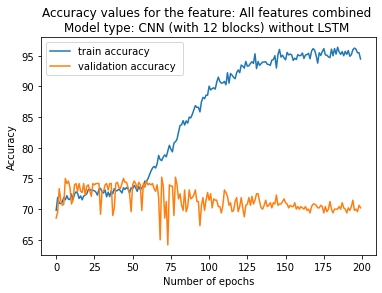

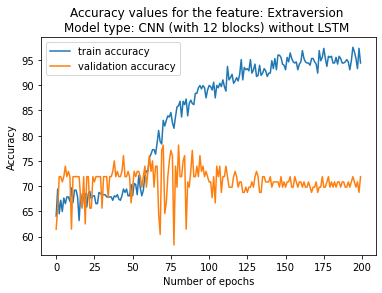

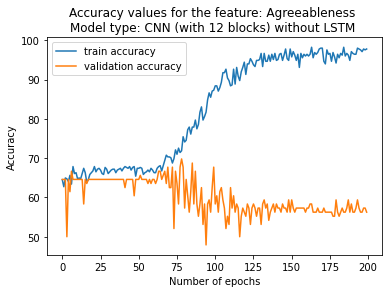

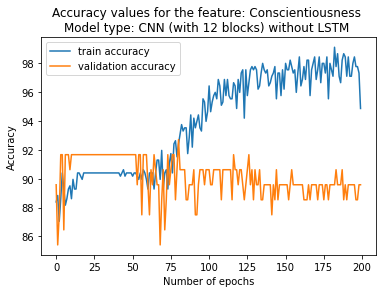

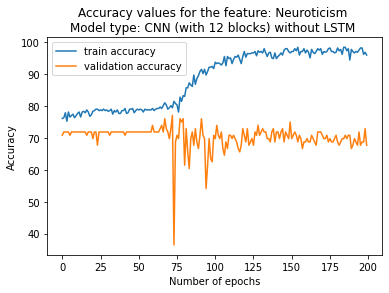

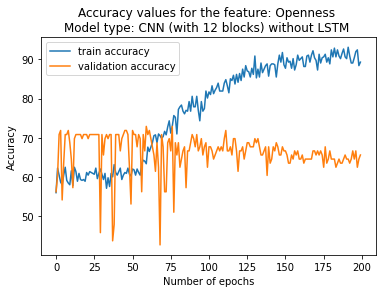

In [3]:
import matplotlib.pyplot as plt

model_type = "CNN (with 12 blocks) without LSTM"

features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

results_df = pd.read_csv("results_cnn_complex_12blocks.csv", header = 0) # results_cnn

plt.plot(results_df['train_accuracy'], label="train accuracy")
plt.plot(results_df['validation_accuracy'], label="validation accuracy ")
plt.title(f"Accuracy values for the feature: All features combined \nModel type: {model_type} ") #; cutoff = {cutoff},
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()

for i in range(5):
    plt.plot(results_df['train_accuracy_' + str(features[i])], label="train accuracy")
    plt.plot(results_df['validation_accuracy_' + str(features[i])], label="validation accuracy")
    plt.title(f"Accuracy values for the feature: {str(features[i])} \nModel type: {model_type} ") #; cutoff = {cutoff},
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()



In [12]:
results_df['validation_accuracy_' + str(features[4])].max()

72.91666666666667